# <font color='green'>**Libraries, Functions and Random Seeds**</font>


In [ ]:
import numpy as np
import tensorflow as tf
import keras

import random

from keras import Sequential
from keras.layers import Input, Dense, LSTM, GRU, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from scipy.stats import beta
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from google.colab import files, drive

In [ ]:
seed_value = 42

# python
random.seed(seed_value)
# numpy
np.random.seed(seed_value)
# tensorflow
tf.random.set_seed(seed_value)

In [ ]:
# Uncomment when importing from GitHub
!git clone https://www.github.com/MorgilloR/time-varying-channels.git
%cd /content/time-varying-channels
dir = '/content/time-varying-channels'

# Uncomment when importing from Google Drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/'Colab Notebooks'/time-varying-channels/
#dir = '/content/drive/MyDrive/"Colab Notebooks"/time-varying-channels'

sys.path.append(dir)
from tvc import *

Cloning into 'time-varying-channels'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 7.93 KiB | 7.93 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/time-varying-channels


# <font color='red'>**Regression**</font>

In [ ]:
# Parameters
n = 20000  # number of data samples
r = 1  # entanglement parameter
steps = 5
a_min, a_max = 0, 0.5  # Range for a
b_min, b_max = 0, 0.5  # Range for b
Delta_exp_min, Delta_exp_max = 10, 30
Delta_cos_min, Delta_cos_max = 1, 10

input_data = []
output_data = []

# Calculate sequence_length here
sequence_length = steps

for i in range(n):  # Iterate through all samples
    if i < n // 5:  # memory (Markovian)
        eta_bar = np.random.uniform(0, 1)
        sigma = np.random.uniform(0, min(eta_bar*(1 - eta_bar)/(1 + 1/eta_bar),
                                            eta_bar*(1 - eta_bar)/(1 + 1/(1-eta_bar))))
        mu = np.random.uniform(0.1, 1)
        eta_sequence = markovian(eta_bar, sigma, mu, sequence_length)

    elif i < 2 * n // 5:  # memoryless
        eta_bar = np.random.uniform(0, 1)
        sigma = np.random.uniform(0, min(eta_bar*(1 - eta_bar)/(1 + 1/eta_bar),
                                            eta_bar*(1 - eta_bar)/(1 + 1/(1-eta_bar))))
        eta_sequence = memoryless(eta_bar, sigma, sequence_length)


    elif i < 3 * n // 5:  # compound
        eta_bar = np.random.uniform(0, 1)
        sigma = np.random.uniform(0, min(eta_bar*(1 - eta_bar)/(1 + 1/eta_bar),
                                            eta_bar*(1 - eta_bar)/(1 + 1/(1-eta_bar))))
        eta_sequence = compound(eta_bar, sigma, sequence_length)

    elif i < 4 * n // 5:  # deterministic
        a = np.random.uniform(a_min, a_max)
        b = np.random.uniform(b_min, b_max)
        eta_sequence = deterministic(a, b, sequence_length, i)

    else:  # non-markovian
        eta_bar = np.random.uniform(0, 1)
        sigma = np.random.uniform(0, min(eta_bar*(1 - eta_bar)/(1 + 1/eta_bar),
                                            eta_bar*(1 - eta_bar)/(1 + 1/(1-eta_bar))))
        mu = np.random.uniform(0.2, 6/11)
        eta_sequence = non_markovian(eta_bar, sigma, mu, sequence_length)

    # Append data for each sample
    eta_sequence = np.array(eta_sequence)
    cov_matrix = diag_cov_matrix(eta_sequence, r)
    input_data.append(cov_matrix)
    output_data.append(eta_sequence)

In [ ]:
X = np.array(input_data)
y = np.array(output_data)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the model
model = Sequential()
model.add(Input(shape=(steps,1)))
#model.add(LSTM(64, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(steps))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=1000, validation_data=(X_test, y_test))

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5659 - val_loss: 0.1437
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1089 - val_loss: 0.0346
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0291 - val_loss: 0.0214
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0210 - val_loss: 0.0185
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0178 - val_loss: 0.0161
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0156 - val_loss: 0.0140
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0136 - val_loss: 0.0119
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - val_loss: 0.0096
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0044
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - lo

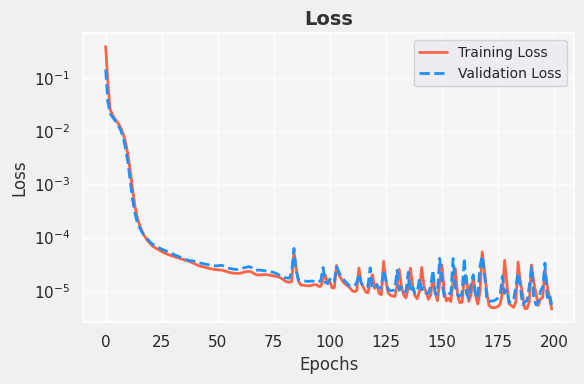

In [ ]:
sns.set(style="darkgrid")

# Create figure with specific background color and size
fig, ax = plt.subplots(figsize=(6, 4), facecolor='#f0f0f0')

# Plot Loss
ax.plot(history.history['loss'], label='Training Loss', color='#FF6347', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation Loss', color='#1E90FF', linestyle='--', linewidth=2)
ax.set_title('Loss', fontsize=14, fontweight='bold', color='#333333')
ax.set_xlabel('Epochs', fontsize=12, color='#333333')
ax.set_ylabel('Loss', fontsize=12, color='#333333')

# Set y-axis to log scale
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better spacing
# Add gridlines (light, dotted)
plt.grid(True, linestyle='-', alpha=0.5, color='white', lw=2)

plt.gca().set_facecolor('#F5F5F5')
plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the validation set
predictions = model.predict(X_test)

# Print ideal and predicted outputs for all values
print("k\tIdeal Outputs\t\tPredicted Outputs")
print("=" * 50)
for i in range(10):
    # Print each k's values
    ideal_output = y_test[i]  # Ideal output for the current sample
    predicted_output = predictions[i]  # Predicted output for the current sample

    # Format the output for better readability
    print(f"Sample {i + 1}:")
    for k in range(steps):
        print(f"\t{k + 1}\t{ideal_output[k]:.4f}\t\t{predicted_output[k]:.4f}")
    print()  # Print a new line for separation between samples

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
k	Ideal Outputs		Predicted Outputs
Sample 1:
	1	0.7650		0.7661
	2	0.7650		0.7661
	3	0.7650		0.7671
	4	0.7650		0.7653
	5	0.7650		0.7659

Sample 2:
	1	0.6641		0.6642
	2	0.7986		0.7996
	3	0.6649		0.6685
	4	0.6267		0.6275
	5	0.4976		0.4986

Sample 3:
	1	0.0392		0.0395
	2	0.0392		0.0396
	3	0.0392		0.0400
	4	0.0392		0.0392
	5	0.0392		0.0396

Sample 4:
	1	0.4903		0.4909
	2	0.5114		0.5120
	3	0.3994		0.4007
	4	0.4067		0.4067
	5	0.3635		0.3638

Sample 5:
	1	0.3255		0.3261
	2	0.3288		0.3294
	3	0.3255		0.3268
	4	0.3164		0.3165
	5	0.3035		0.3041

Sample 6:
	1	0.2633		0.2639
	2	0.2633		0.2639
	3	0.2633		0.2645
	4	0.2633		0.2634
	5	0.2633		0.2639

Sample 7:
	1	0.4925		0.4933
	2	0.4925		0.4933
	3	0.4925		0.4941
	4	0.4925		0.4927
	5	0.4925		0.4932

Sample 8:
	1	0.9722		0.9736
	2	0.9626		0.9638
	3	0.9643		0.9668
	4	0.9678		0.9682
	5	0.9738		0.9748

Sample 9:
	1	0.3409		0.3416
	2	0.3398		0.3405
	3	0.3290		0.3303
	4	0.3442		0.3444
	5	0.3434		0.3440

Sample 10:
	1	0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

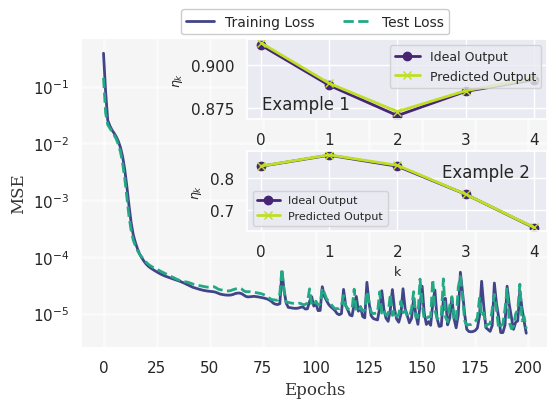

In [ ]:
sns.set(style="darkgrid")

# Create the main figure for the loss curve
fig, ax = plt.subplots(figsize=(6, 4), facecolor='#f0f0f0')

# Create a Viridis colormap
cmap = plt.cm.viridis

# Plot Loss
ax.plot(history.history['loss'], label='Training Loss', color=cmap(0.2), linewidth=2)
ax.plot(history.history['val_loss'], label='Test Loss', color=cmap(0.6), linestyle='--', linewidth=2)
ax.set_xlabel('Epochs', fontsize=12, color='#333333', family='serif')
ax.set_ylabel('MSE', fontsize=12, color='#333333', family='serif')

# Set y-axis to log scale
ax.set_yscale('log')
ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2, title_fontsize='13', facecolor='white', framealpha=1)
ax.grid(True, linestyle='--', alpha=0.6)

# Remove the surrounding frame in the main plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Ensure the background is white
fig.patch.set_facecolor('white')  # Set the entire figure's background to white
ax.set_facecolor('white')         # Set only the main plot background to white

# Adjust layout for better spacing
plt.grid(True, linestyle='-', alpha=0.5, color='white', lw=2)
plt.gca().set_facecolor('#F5F5F5')


ideal_output_10 = y_test[10]
predicted_output_10 = predictions[10]  # Predicted output for the first representative sample

ideal_output_9 = y_test[40]  # Ideal output for the second representative sample
predicted_output_9 = predictions[40]  # Predicted output for the second representative sample

# Generate k values (steps) for the plot
k_values = np.arange(len(ideal_output_10))

# Create insets
ax_inset1 = fig.add_axes([0.4, 0.68, 0.5, 0.2])  # Positioning the first inset
ax_inset1.plot(k_values, ideal_output_10, label="Ideal Output", marker='o', color=cmap(0.1), linewidth=2)
ax_inset1.plot(k_values, predicted_output_10, label="Predicted Output", marker='x', color=cmap(0.9), linewidth=2)
ax_inset1.set_xlabel("k", fontsize=8)
ax_inset1.set_ylabel(r"$\eta_k$", fontsize=9)
ax_inset1.legend(fontsize=9)
ax_inset1.text(0.05, 0.3, "Example 1", transform=ax_inset1.transAxes, fontsize=12, va='top', ha='left')

ax_inset2 = fig.add_axes([0.4, 0.4, 0.5, 0.2])  # Positioning the second inset
ax_inset2.plot(k_values, ideal_output_9, label="Ideal Output", marker='o', color=cmap(0.1), linewidth=2)
ax_inset2.plot(k_values, predicted_output_9, label="Predicted Output", marker='x', color=cmap(0.9), linewidth=2)
ax_inset2.set_xlabel("k", fontsize=9)
ax_inset2.set_ylabel(r"$\eta_k$", fontsize=9)
ax_inset2.legend(fontsize=8)
ax_inset2.text(0.65, 0.85, "Example 2", transform=ax_inset2.transAxes, fontsize=12, va='top', ha='left')

# Show the plot
#plt.tight_layout()
#plt.show()

# Save the plot to a PDF file
plt.savefig("regression.pdf", bbox_inches='tight', pad_inches=0.25, format="pdf")

# Download the file
files.download("regression.pdf")